In [17]:
import meshio
import pygalmesh
import numpy as np
import copy
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? 

In [18]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=1
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=1
# the spring prestress 
g0start=3.5
g0end=4.0
g0step=0.1

#logging interval
LogInterval=50000

Right, lets define the bond type and parameters for each bond. In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [19]:
kd=kc/target_a
k = mu
theta0=np.pi

Set up the experiment

In [20]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
RunFolder="Sweep/"
# Name of the run
RunName="Disk"
# Name of the current file
ScriptName="EnergyMinimizationScript.ipynb"

path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder if there was a previous run in it
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "mu":mu,
        "g0start":g0start,
        "g0end":g0end,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Sweep/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Sweep/EnergyMinimizationScript.ipynb'

Make the mesh, write it out to the folder

In [21]:
InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples = MakeDolfinMesh(target_a,40)
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk")

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.15691819145568991

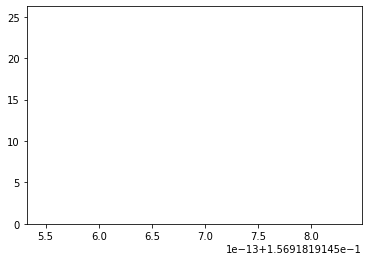

In [22]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

# Energy Minimization

In [23]:
def mycallback(xi):
    counter=len(history)
    history.append(xi)
    print(counter)
    tempP = xi.reshape((-1, 2))
    #output for visualisation
    OutputMesh.points[:,0:2] = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+"TempOutput"+"Output"+"{0:0.1f}".format(g0)+"_"+str(counter)+".vtk",binary=True)

In [24]:
# initial input points. Pout changes over time
Pout_ij =InputMesh.points[:,0:2] 
N = len(Pout_ij)

# the connectivity matrix --- this doesnt change over the run
A = np.zeros( (len(Pout_ij),len(Pout_ij)) )
for bond in edgebonds+interiorbonds:
    A[bond[0],bond[1]]=1
    A[bond[1],bond[0]]=1

# the triangles defining the connectivity data    
triangles=InputMesh.cells[0].data
# The initial area, which we want to penalise deviation from
TargetArea=TotalArea(Pout_ij,triangles)

for g0 in np.arange(g0start,g0end,g0step):
    
    print("Current g0"+"{0:0.1f}".format(g0))
    
    # Make the "prestress" matrix, referring to scale factors for the rest lengths
    g0_ij= np.ones((N,N),)
    for bond in edgebonds:
        g0_ij[bond[0],bond[1]]=g0
        g0_ij[bond[1],bond[0]]=g0   
    # the preferred rest lengths of all the springs
    r0_ij = g0_ij*dist(InputMesh.points[:,0:2] )

    # minimize
    history=[]
    Pout_ij = opt.minimize(energy, Pout_ij.ravel()
                           ,args=(A,r0_ij,angletriples,triangles,k,kd,theta0,B,TargetArea)
                           ,callback=mycallback
                           ,options={'disp': True}).x.reshape((-1, 2))
   
    # print the output 
    OutputMesh.points[:,0:2] = Pout_ij         
    OutputMesh.write(DataFolder+RunFolder+RunName+"Output"+"{0:0.1f}".format(g0)+".vtk",binary=True)


Current g03.5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
Optimization terminated successfully.
         Current function value: 21.642658
         Iterations: 99
         Function evaluations: 32725
         Gradient evaluations: 119
Current g03.6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
Optimization terminated successfully.
         Current function value: 22.757394
         Iterations: 92
         Function evaluations: 29425
         Gradient evaluations: 107
Current g03.7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2